## Ensemble learning for activity recognition

### 1. Set libraries

In [3]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras import optimizers
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from random import randint
from numpy import array
from numpy import argmax
from pandas import DataFrame
from pandas import concat
from keras.layers import GRU, LSTM, Activation, Bidirectional
from keras.layers import Dense, Embedding
from keras.layers import TimeDistributed
from keras.layers import Concatenate, Flatten 
from keras.layers import Dense, concatenate
import time
import matplotlib.pyplot as plt
# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from numpy import dstack
#from attention import Attention

# univariate cnn lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import SpatialDropout1D
from keras.layers import ConvLSTM2D
from scipy.optimize import differential_evolution
from sklearn.datasets import make_blobs

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
import os

In [ ]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# one hot encode output variable
y = to_categorical(y)

In [ ]:
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

In [ ]:
# fit model on dataset
def fit_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=500, verbose=0)
	return model

In [ ]:
# create directory for models
#akedirs('models')

In [ ]:
# fit and save models
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(trainX, trainy)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

In [7]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [8]:
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [9]:
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

In [10]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [11]:
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded models/model_1.h5
>loaded models/model_2.h5
>loaded models/model_3.h5
>loaded models/model_4.h5
>loaded models/model_5.h5
Loaded 5 models


In [12]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [13]:
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

Model Accuracy: 0.817
Model Accuracy: 0.810
Model Accuracy: 0.807
Model Accuracy: 0.813
Model Accuracy: 0.807


NameError: name 'LogisticRegression' is not defined

In [ ]:
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=300, verbose=0)
 
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

In [ ]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

## Integrated Stacking Model

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

In [ ]:
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [ ]:
# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
#	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy_enc, epochs=300, verbose=0)

In [ ]:
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)

In [ ]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

In [ ]:
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

In [ ]:
# load all models
n_members = 5
members = load_all_models(n_members)

In [ ]:
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)

In [ ]:
# fit stacked model on test dataset
fit_stacked_model(stacked_model, testX, testy)

In [ ]:
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

In [ ]:
# LSTM and CNN for sequence classification in the IMDB dataset
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
layers.concatenate
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
arr = [] #  empty regular list
for i in range(len(dataframe1)):
    arr.append(1*np.ones((1)))
for i in range(len(dataframe2)):
    arr.append(2*np.ones((1)))
for i in range(len(dataframe3)):
    arr.append(3*np.ones((1)))
for i in range(len(dataframe4)):
    arr.append(4*np.ones((1)))
np_array = np.array(arr)  # transformed to a numpy array

da = pd.DataFrame({'': np_array[:, 0]})
print(da)

In [ ]:
from attention_keras.layers.attention import AttentionLayer


In [45]:
!pip install attention

Unable to create process using 'C:\Users\Hyunju Kim\.conda\envs\tf2.0-gpu\python.exe "C:\Users\Hyunju Kim\.conda\envs\tf2.0-gpu\Scripts\pip-script.py" install attention'


In [5]:
# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
print(testX.shape)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)


ValueError: Unknown initializer: GlorotUniform

In [6]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [10]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
print(y)

[2 0 2 ... 1 0 2]


In [11]:
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
print(trainy.shape, testy.shape)

(100, 2) (1000, 2)
(100,) (1000,)


In [12]:

# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

# stacked generalization with linear meta model on blobs dataset
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
 
# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models
 
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX
 
# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model
 
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat
 
# generate 2d classification dataset
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# split into train and test
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)
# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# evaluate standalone models on test dataset
for model in members:
	testy_enc = to_categorical(testy)
	_, acc = model.evaluate(testX, testy_enc, verbose=0)
	print('Model Accuracy: %.3f' % acc)
# fit stacked model using the ensemble
model = fit_stacked_model(members, testX, testy)
# evaluate model on test set
yhat = stacked_prediction(members, model, testX)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

(100, 2) (1000, 2)


ValueError: Unknown initializer: GlorotUniform

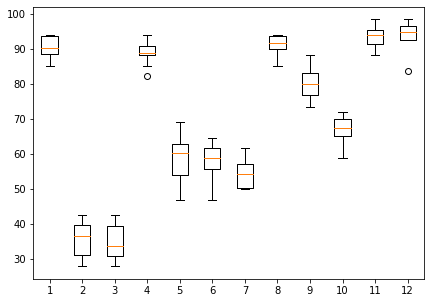

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
  
  
# Creating dataset 
data_to_plot = [[85.2,88.2,92.6,89.7,91.1,94.1,89.7,88.2,94.1,94.1],
                [35.2,29.4,39.7,30.8,39.7,27.9,39.7,38.2,42.6,32.3],
                [35.2,29.4,39.7,30.8,30.8,27.9,39.7,38.2,42.6,32.3],
                [85.2,94.1,89.7,91.1,82.3,94.1,88.2,88.2,89.7,88.2],
                [60.2,63.2,57.3,67.6,52.9,69.1,60.2,47,61.7,50],
                [55.8,61.7,57.3,64.7,55.8,61.7,60.2,47,64.7,52.9],
                [57.3,55.8,57.3,58.8,50,61.7,50,51.4,52.9,50],
                [85.2,91.1,92.6,92.6,91.1,94.1,89.7,88.2,94.1,94.1],
                [73.5,76.4,83.8,80.8,77.9,88.2,83.8,76.4,80.8,79.4],
                [66.1,61.7,69.1,70.5,58.8,72,67.6,64.7,72,67.6],
                [88.2,95.6,95.6,95.6,91.2,98.5,91.2,92.6,94.1,94.1],
                [94.1,92.6,83.8,92.6,95.5,95.5,92.6,97,97,98.5]
                ]
  
fig = plt.figure(figsize =(7, 5)) 
  
# Creating plot 
plt.boxplot(data_to_plot ) 
  
# show plot 
plt.show() 

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
  
  
# Creating dataset 
data_to_plot = [[92.6,89.7,],
                [35.2,29.4,39.7,30.8,39.7,27.9,39.7,38.2,42.6,32.3],
                [35.2,29.4,39.7,30.8,30.8,27.9,39.7,38.2,42.6,32.3],
                [85.2,94.1,89.7,91.1,82.3,94.1,88.2,88.2,89.7,88.2],
                [60.2,63.2,57.3,67.6,52.9,69.1,60.2,47,61.7,50],
                [55.8,61.7,57.3,64.7,55.8,61.7,60.2,47,64.7,52.9],
                [57.3,55.8,57.3,58.8,50,61.7,50,51.4,52.9,50],
                [85.2,91.1,92.6,92.6,91.1,94.1,89.7,88.2,94.1,94.1],
                [73.5,76.4,83.8,80.8,77.9,88.2,83.8,76.4,80.8,79.4],
                [66.1,61.7,69.1,70.5,58.8,72,67.6,64.7,72,67.6],
                [88.2,95.6,95.6,95.6,91.2,98.5,91.2,92.6,94.1,94.1],
                [94.1,92.6,83.8,92.6,95.5,95.5,92.6,97,97,98.5]
                ]
  
fig = plt.figure(figsize =(7, 5)) 
  
# Creating plot 
plt.boxplot(data_to_plot ) 
  
# show plot 
plt.show() 

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [ ]:
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 40, 40, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [ ]:
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the model to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1)

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0
                ] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [ ]:
epochs = 1  # In practice, you would need hundreds of epochs.

noisy_movies, shifted_movies = generate_movies(n_samples=1200)
seq.fit(
    noisy_movies[:1000],
    shifted_movies[:1000],
    batch_size=10,
    epochs=epochs,
    verbose=2,
    validation_split=0.1,
)

In [ ]:
movie_index = 1004
test_movie = noisy_movies[movie_index]

# Start from first 7 frames
track = test_movie[:7, ::, ::, ::]

# Predict 16 frames
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

In [ ]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])